In [22]:
from __future__ import print_function
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
#from keras import backend as K
!pip install pandas
!pip install matplotlib

import random
import numpy as np
import pandas as pd

import scipy.io
from scipy.signal import spectrogram
import matplotlib.pyplot as plt

In [ ]:
#pip uninstall firebase-admin

In [10]:
 pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [29]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [23]:
#Visualizing an example:
interictal_tst = 'C:/Users/Sara/Desktop/Patient_1/Patient_1_interictal_segment_0001.mat'
preictal_tst = 'C:/Users/Sara/Desktop/Patient_1/Patient_1_preictal_segment_0001.mat'
interictal_data = scipy.io.loadmat(interictal_tst)
preictal_data = scipy.io.loadmat(preictal_tst)


In [24]:
interictal_array = interictal_data['interictal_segment_1'][0][0][0]
preictal_array = preictal_data['preictal_segment_1'][0][0][0]

Interictal


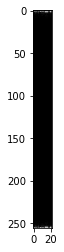

Preictal


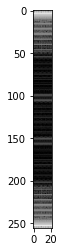

Interictal


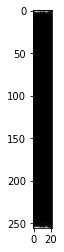

Preictal


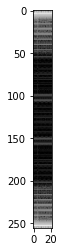

In [25]:
# Taking 1 second worth of data of channel 0 for preictal example
l = list(range(10000))
for i in l[::5000]:
    print('Interictal')
    i_secs = interictal_array[0][i:i+5000]
    i_f, i_t, i_Sxx = spectrogram(i_secs, fs=5000, return_onesided=False)
    i_SS = np.log1p(i_Sxx)
    plt.imshow(i_SS[:] / np.max(i_SS), cmap='gray')
    plt.show()
    print('Preictal')
    p_secs = preictal_array[0][i:i+5000]
    p_f, p_t, p_Sxx = spectrogram(p_secs, fs=5000, return_onesided=False)
    p_SS = np.log1p(p_Sxx)
    plt.imshow(p_SS[:] / np.max(p_SS), cmap='gray')
    plt.show()

In [26]:
# Creating training and testing data
all_X = []
all_Y = []

types = ['Patient_1_interictal_segment', 'Patient_1_preictal_segment']

for i,typ in enumerate(types):
    # Looking at 18 files for each event for a balanced dataset
    for j in range(18):
        fl = 'Patient_1/{}_{}.mat'.format(typ, str(j + 1).zfill(4))
        
        data = scipy.io.loadmat(fl)
        
        k = typ.replace('Patient_1_', '') + '_'
        
        d_array = data[k + str(j + 1)][0][0][0]
        lst = list(range(3000000))  # 10 minutes
        for m in lst[::5000]:
            # Create a spectrogram every 1 second
            p_secs = d_array[0][m:m+5000]
            p_f, p_t, p_Sxx = spectrogram(p_secs, fs=5000, return_onesided=False)
            p_SS = np.log1p(p_Sxx)
            arr = p_SS[:] / np.max(p_SS)
            all_X.append(arr)
            all_Y.append(i)
            

In [27]:
# Shuffling the data
dataset = list(zip(all_X, all_Y))
random.shuffle(dataset)
all_X,all_Y = zip(*dataset)
print(len(all_X))

21600


In [28]:
# Splitting data into train/test, leaving only 600 samples for testing
x_train = np.array(all_X[:21000])
y_train = np.array(all_Y[:21000])
x_test = np.array(all_X[21000:])
y_test = np.array(all_Y[21000:])

In [29]:
batch_size = 128
num_classes = 2
epochs = 30
img_rows, img_cols = 256, 22

In [10]:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [30]:
# Formatting the labels for training
y_train = tf.keras.utils.to_categorical(y_train, num_classes) 
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

In [31]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.6))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.RMSprop(),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 254, 20, 32)       320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 252, 18, 64)       18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 9, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 126, 9, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 72576)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2322464   
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)               

In [ ]:
input_shape

In [ ]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/30
 72/165 [============>.................] - ETA: 19:43 - loss: 0.5120 - accuracy: 0.6472

In [ ]:
model.save('C:/Users/Sara/Desktop/model_2.h5')

In [69]:
#Those are the output predictions of the test images of the dataset American Society for epilepsy
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
label_mapping = {'Interictal': 0,'Preictal':1}
model = tf.keras.models.load_model(r"C:\Users\Sara\Desktop\TensorLight")
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
from sklearn.metrics import confusion_matrix, classification_report

X_test=np.reshape(x_test,(x_test.shape[0], x_test.shape[1],x_test.shape[2],1))

y_pred = np.array(list(map(lambda x: np.argmax(x), model.predict(X_test))))
print("X=%s,Predicted=%s" %(X_test[0],y_pred))
#print(X_test.shape)

#cm = confusion_matrix(X_test, y_pred)
#clr = classification_report(X_test, y_pred, target_names=label_mapping.keys())

#plt.figure(figsize=(2, 2))
#sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
#plt.xticks(np.arange(2) + 0.5, label_mapping.keys())
#plt.yticks(np.arange(2) + 0.5, label_mapping.keys())
#plt.xlabel("Predicted")
#plt.ylabel("Actual")
#plt.title("Confusion Matrix")
#plt.show()
#print(y_pred)
#print("Classification Report:\n----------------------\n", clr)
#classes = model.predict_classes(X_test)



#print(y_pred)


X=[[[0.02697417]
  [0.05064695]
  [0.01312329]
  ...
  [0.00300981]
  [0.01642242]
  [0.19779736]]

 [[0.9560554 ]
  [0.6019976 ]
  [0.66370547]
  ...
  [0.8781989 ]
  [0.17818464]
  [0.6921619 ]]

 [[0.04232931]
  [0.21422076]
  [0.0862736 ]
  ...
  [0.508354  ]
  [0.08935078]
  [0.08270384]]

 ...

 [[0.112652  ]
  [0.00582936]
  [0.05044131]
  ...
  [0.03458675]
  [0.01503083]
  [0.22645701]]

 [[0.04232931]
  [0.21422076]
  [0.0862736 ]
  ...
  [0.508354  ]
  [0.08935078]
  [0.08270384]]

 [[0.9560554 ]
  [0.6019976 ]
  [0.66370547]
  ...
  [0.8781989 ]
  [0.17818464]
  [0.6921619 ]]],Predicted=[0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 1 1 0 0 0 0 1 0 0 0 1 0 0
 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 1 0 0 0 0 0 

In [ ]:
#!pip install python-firebase
#!pip install firebase_admin

In [33]:
#pip install --upgrade firebase-admin

Note: you may need to restart the kernel to use updated packages.


In [85]:
#val = np.float32(0)
#pyval = val.item()
#print(type(pyval))  
val=(y_pred[0].item())
type(val)
print(val)

0


In [71]:
type(y_pred[0])

numpy.int64

In [72]:
from firebase import firebase 
#from firebase import child
#|auth = firebase.FirebaseAuthentication(FIREBASE_SECRET, 'firebase@firebase.com', 'fbpw')
myDB=firebase.FirebaseApplication("https://epilepsy5-default-rtdb.firebaseio.com/Trial",None)

In [51]:
firebase.FirebaseApplication?


In [21]:
# import firebase_admin
# from firebase_admin import credentials
# from firebase_admin import firestore
# cred = credentials.Certificate(r"C:/Users/Sara/Desktop/epilepsy-seizure-firebase-adminsdk-t5y2k-99feb60b5c.json")
# firebase_admin.initialize_app(cred)
# db = firestore.client()
# users_ref = db.collection(u'Predictions')
# docs = users_ref.stream()

# for doc in docs:
#     print(f'{doc.id} => {doc.to_dict()}')

# # Create a reference for the document before setting
# data = {
#     'ID': 'IVL1gDEkb5V365Rgk1DCxTRq0pu3',
#     'status': '0'
# }

# # Add a new doc in collection 'persons' with ID 'HP'
# db.collection('Predictions').document('hp1').set(data)

In [20]:
# import firebase_admin
# from firebase_admin import credentials


# doc_ref = db.collection(u'Predictions').document(u'')
# doc_ref.set({
#     u'ID': u'OVL1gDEkb5V365Rgk1DCxTRq0pu2',
#     u'Status': u'0'
# })

In [19]:
# import firebase_admin
# from firebase_admin import credentials


# #cred = credentials.Certificate("path/to/serviceAccountKey.json")
# firebase_admin.initialize_app(cred)

In [25]:
val=(y_pred[9].item())
type(val)
print(val)

0


In [87]:
name=input('Enter name')
data={
    
    "prediction":val
}
   
myDB.patch("Trial",data)

Enter namesara


{'prediction': 0}

In [22]:
# myDB("User").("-N2gc459ByQ7RFMU-P1A").update({"prediction": val})

In [ ]:
#import pandas as pd

#import matplotlib.pyplot as plt
#import seaborn as sns
#label_mapping = {'Interictal': 0,'Preictal':1}
#from sklearn.metrics import confusion_matrix, classification_report

#y_pred = np.array(list(map(lambda x: np.argmax(x), model.predict(X_test))))
#print("X=%s,Predicted=%s" %(X_test,y_pred))
#cm = confusion_matrix(y_test, y_pred)
#clr = classification_report(y_test, y_pred, target_names=label_mapping.keys())

#plt.figure(figsize=(2, 2))
#sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
#plt.xticks(np.arange(2) + 0.5, label_mapping.keys())
#plt.yticks(np.arange(2) + 0.5, label_mapping.keys())
#plt.xlabel("Predicted")
#plt.ylabel("Actual")
#plt.title("Confusion Matrix")
#plt.show()
#print(y_pred)
#print("Classification Report:\n----------------------\n", clr)

In [ ]:
import numpy as np
import pandas as pd
prediction = pd.DataFrame(classes, columns=['predictions']).to_csv('prediction.csv')